# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

Ayeen Poostforoushan



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [2]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [4]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    x_hat = (x - mean) / np.sqrt(variance + epsilon)
    out = gamma * x_hat + beta
    return out


In [5]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [6]:
# TRANSFORMS
normalize_mean = [0.5071, 0.4867, 0.4408]
normalize_std = [0.2675, 0.2565, 0.2761]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean,
                         std=normalize_std),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean,
                        std=normalize_std),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
half_size = len(train_set)//2
train_subset = Subset(train_set, range(half_size))
train_loader = DataLoader(train_subset, batch_size=32, shuffle=False, num_workers=4)

# VALIDATION DATA
validation_subset = Subset(train_set, range(half_size, len(train_set)))
val_loader = DataLoader(validation_subset, batch_size=32, shuffle=False, num_workers=4)

# TODO: create test
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:02<00:00, 73371566.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:
<br/>
*answer*


In transform_train, we applied a series of transformations to augment the training data, including random horizontal flips and random cropping, followed by converting the images to tensors and normalizing them. This helps in making the model more robust to variations in the input data. In transform_test, we only converted the images to tensors and normalized them, ensuring that the test data is preprocessed in the same way as the training data but without any augmentation. This ensures consistency in data preprocessing while evaluating the model's performance.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

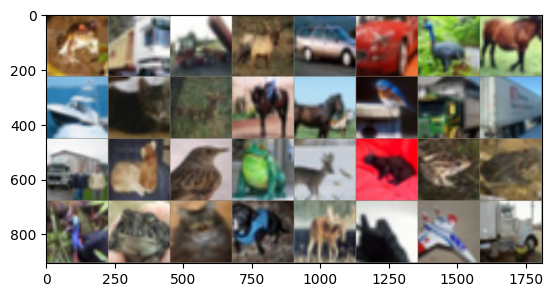

labels are:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


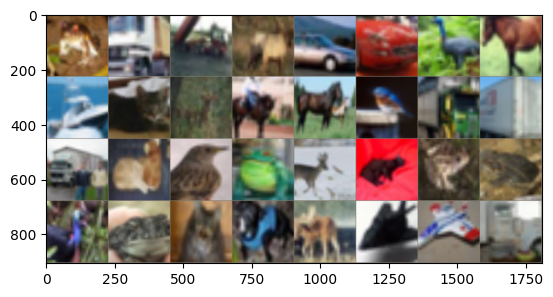

labels are:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


In [7]:
# for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.
def imshow(img : torch.Tensor):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(normalize_mean)
    std = np.array(normalize_std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()


# show some training images with shuffle=False and labels
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

print("labels are: ", labels)

# show them again to check the augmentation
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

print("labels are: ", labels)

# create train loader with shuffle true
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [8]:
MODEL_SAVE_PATH = './model.pt'

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    if train_mode:
        model.train()
    else:
        model.eval()

    epoch_losses = []
    for data in tqdm(data_loader, desc="Training" if train_mode else "Validation"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_losses.append(loss.item())

        if train_mode:
            loss.backward()
            optimizer.step()

    return epoch_losses

def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    
    start = time.time()

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_epoch_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_epoch_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        train_losses.extend(train_epoch_losses)
        val_losses.extend(val_epoch_losses)

        print(f'Epoch {epoch+1} training loss: {np.mean(train_epoch_losses):.2f}, validation loss: {np.mean(val_epoch_losses):.2f}, Time: {time.time()-start:.2f}s')

        # Save the model after each epoch
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        
    print(f"Total training time: {time.time()-start:.2f}s")

    return train_losses, val_losses

def get_acc(
    model: nn.Module,
    val_loader: DataLoader,
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.
        device (torch.device): The device to run the model on.

    Returns:
        float: Validation accuracy.
    """
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10,
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    # Smooth the training losses
    plt.figure(figsize=(10, 5))
    plt.plot(
        np.convolve(train_losses, np.ones(c_window)/c_window, mode='valid'),
        label="Train Loss",
    )
    plt.plot(
        np.convolve(val_losses, np.ones(c_window)/c_window, mode='valid'),
        label="Validation Loss",
    )
    plt.xlabel("Batch iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [9]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False), # padding 1 for same size output
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**
Depthwise separable convolutions factorize a standard convolution into two layers: (depthwise convolution) and pointwise convolution (1x1 convolution).

Computational cost comparison:
*   Standard convolution filters and combines inputs in one step, with a computational cost of DK * DK * M * N * DF * DF.
*   Depthwise convolution applies a single filter to each input channel, and has a cost of DK * DK * M * DF * DF.
*   Pointwise convolution uses a 1x1 convolution to create a linear combination of the depthwise layer's output, with a cost of M * N * DF * DF.

The total cost of depthwise separable convolution is the sum of these two steps: DK * DK * M * DF * DF  + M * N * DF * DF. This factorization leads to a reduction in computation. The reduction in computation is (DK * DK * M * DF * DF  + M * N * DF * DF) / (DK * DK * M * N * DF * DF )= 1/N + 1/(DK^2).  MobileNets use 3x3 depthwise separable convolutions, which results in 8 to 9 times less computation than standard convolutions.

Now please create your model.

In [10]:
class MobileNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.model = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)
        
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [11]:
epochs = 10
lr = 1e-3
n_class = 10

mobile_netv1_model = MobileNet(n_class).to(device)
train_losses, val_losses = train(train_loader, val_loader, mobile_netv1_model, epochs, lr)

Epoch 1/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 training loss: 1.64, validation loss: 1.53, Time: 107.66s
Epoch 2/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 training loss: 1.30, validation loss: 1.18, Time: 226.40s
Epoch 3/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 training loss: 1.12, validation loss: 0.99, Time: 344.03s
Epoch 4/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 training loss: 0.96, validation loss: 0.89, Time: 461.34s
Epoch 5/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 training loss: 0.86, validation loss: 0.84, Time: 578.53s
Epoch 6/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 training loss: 0.78, validation loss: 0.76, Time: 695.92s
Epoch 7/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 training loss: 0.73, validation loss: 0.70, Time: 813.43s
Epoch 8/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8 training loss: 0.67, validation loss: 0.67, Time: 930.96s
Epoch 9/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9 training loss: 0.62, validation loss: 0.67, Time: 1048.54s
Epoch 10/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10 training loss: 0.58, validation loss: 0.61, Time: 1165.95s
Total training time: 1165.99s


Get some metrics and plot your losses.

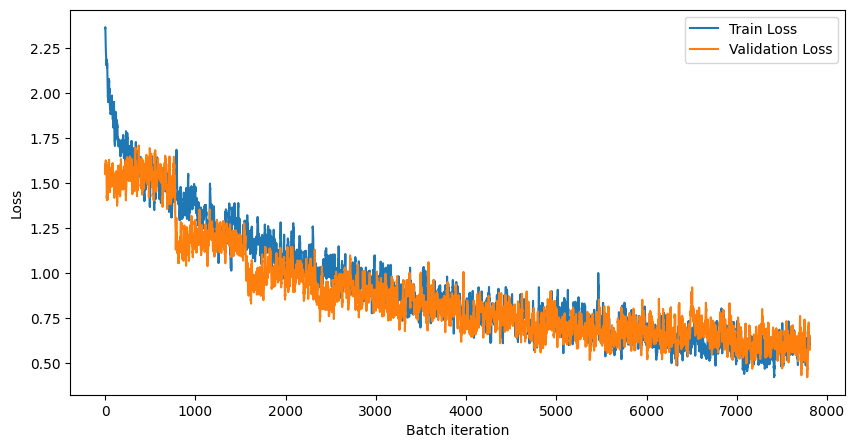

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 79.216
Process validation time: 32.8752 s


In [13]:
plot_losses(train_losses, val_losses)

start = time.time()
val_acc = get_acc(mobile_netv1_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**

Standard Convolution FLOPs: DK * DK * M * N * DF * DF.

Depthwise Separable Convolution FLOPs: DK * DK * M * DF * DF + M * N * DF * DF.

This is the sum of the FLOPs for the depthwise convolution and the pointwise (1x1) convolution.

Ratio of Depthwise Separable to Standard Convolution FLOPs: (DK * DK * M * DF * DF + M * N * DF * DF) / (DK * DK * M * N * DF * DF) = 1/N + 1/(DK^2)

MobileNets use 3x3 kernels, so DK = 3. When the number of output channels (N) is large, the term 1/N becomes very small, and the reduction ratio tends towards 1/9. This means that depthwise separable convolutions reduce the computational cost by a factor of approximately 9, which leads to the claim that MobileNets are 8 to 9 times faster than networks using standard convolutions.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [14]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [15]:
# TODO: train model
epochs = 2
lr = 1e-3
n_class = 10

normal_model = NormalCNN(n_class).to(device)
train_losses, val_losses = train(train_loader, val_loader, normal_model, epochs, lr)

Epoch 1/2


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 training loss: 1.97, validation loss: 1.77, Time: 221.94s
Epoch 2/2


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 training loss: 1.73, validation loss: 1.77, Time: 443.44s
Total training time: 443.75s


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 34.164
Process validation time: 52.9272 s


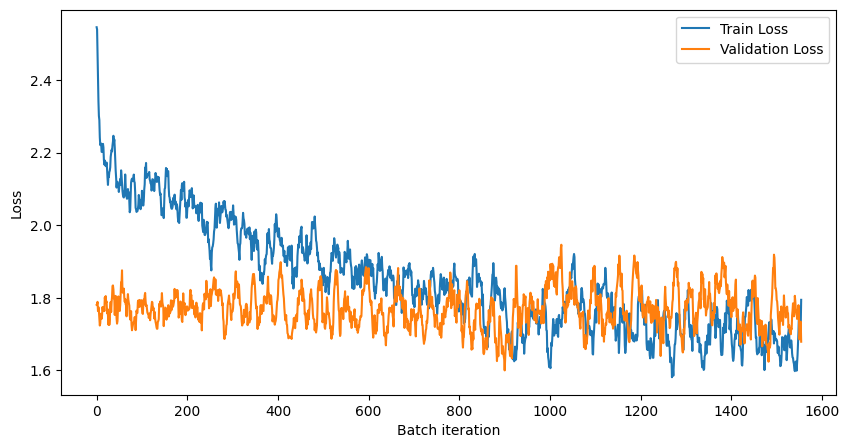

In [16]:
start = time.time()
val_acc = get_acc(normal_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**

MobileNet was faster (1165s for 10 epochs) compared to the normal CNN (443s for 2 epochs), this indicates that MobileNet is more efficient in training, likely due to its lighter architecture with depthwise separable convolutions, which reduce the number of parameters and operations per epoch. Despite having more epochs, MobileNet's design allows it to process data faster per epoch, while the normal CNN might have a larger or more complex structure that takes longer to train even for fewer epochs. This suggests that MobileNet’s efficiency comes from fewer parameters and computations, leading to faster learning and validation times despite having more epochs.

In [17]:
# TODO: compare number of parameters in these two models
mobilenet_params = sum(p.numel() for p in mobile_netv1_model.parameters())
normalcnn_params = sum(p.numel() for p in normal_model.parameters())

print('Total number of normal CNN parameters:', normalcnn_params)
print('Total number of MobileNet parameters:', mobilenet_params)

Total number of normal CNN parameters: 28279338
Total number of MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [18]:
transfer_learning_model = MobileNet(n_class=100).to(device)

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
pre_trained = torch.load('model.pt', map_location=device)

# Filter out unnecessary keys from the pretrained dict
model_state_dict = transfer_learning_model.state_dict()

pre_trained_dict = {k: v for k, v in model_state_dict.items() if k in pre_trained and 'fc' not in k}

# Load the pre-trained weights into the model
model_state_dict.update(pre_trained_dict)

# Load the updated model state
transfer_learning_model.load_state_dict(model_state_dict)

<ipython-input-18-7f37f0f91b2c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre_trained = torch.load('model.pt', map_location=device)


<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [30]:
# Freeze up to the desired layer (e.g., the first 7 layers)
for name, param in transfer_learning_model.named_parameters():
    layer = name.split('.')[1]
    if layer[0] == 'model':
        if int(layer) <= 7:
            param.requires_grad = False
        
for name, param in transfer_learning_model.named_parameters():
    if param.requires_grad:
        print(f"Training: {name}")
    else:
        print(f"Freezing: {name}")

Freezing: model.0.0.weight
Freezing: model.0.1.weight
Freezing: model.0.1.bias
Freezing: model.1.0.weight
Freezing: model.1.1.weight
Freezing: model.1.1.bias
Freezing: model.1.3.weight
Freezing: model.1.4.weight
Freezing: model.1.4.bias
Freezing: model.2.0.weight
Freezing: model.2.1.weight
Freezing: model.2.1.bias
Freezing: model.2.3.weight
Freezing: model.2.4.weight
Freezing: model.2.4.bias
Freezing: model.3.0.weight
Freezing: model.3.1.weight
Freezing: model.3.1.bias
Freezing: model.3.3.weight
Freezing: model.3.4.weight
Freezing: model.3.4.bias
Freezing: model.4.0.weight
Freezing: model.4.1.weight
Freezing: model.4.1.bias
Freezing: model.4.3.weight
Freezing: model.4.4.weight
Freezing: model.4.4.bias
Freezing: model.5.0.weight
Freezing: model.5.1.weight
Freezing: model.5.1.bias
Freezing: model.5.3.weight
Freezing: model.5.4.weight
Freezing: model.5.4.bias
Freezing: model.6.0.weight
Freezing: model.6.1.weight
Freezing: model.6.1.bias
Freezing: model.6.3.weight
Freezing: model.6.4.weigh

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [31]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169001437/169001437 [00:01<00:00, 96435860.57it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

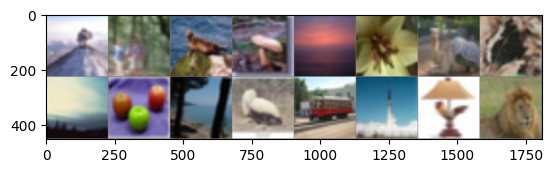

labels are:  tensor([49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43])


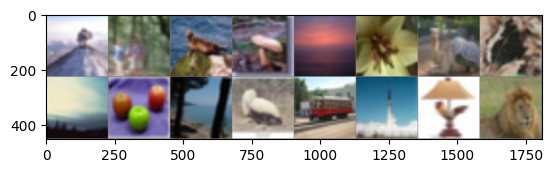

labels are:  tensor([49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43])


In [34]:
# show some training images with shuffle=False and labels
images, labels = next(iter(val_loader100))
imshow(torchvision.utils.make_grid(images[:16]))

print("labels are: ", labels[:16])

# show them again to check the augmentation
images, labels = next(iter(val_loader100))
imshow(torchvision.utils.make_grid(images[:16]))

print("labels are: ", labels[:16])

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer** No, **CIFAR-10** and **CIFAR-100** do not use the same images with different labels. While both datasets contain 60,000 32x32 color images, **CIFAR-10** has 10 broad classes, like airplane and dog, while **CIFAR-100** has 100 more detailed classes, such as apple, orange, and beech. The images are the same in both, but the labels are different, with CIFAR-100 offering more fine-grained classifications and an additional "superclass" grouping for related classes.

Now train your model using your functions.

In [35]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, transfer_learning_model, epochs, lr)

Epoch 1/7


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 training loss: 4.41, validation loss: 4.24, Time: 53.26s
Epoch 2/7


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 training loss: 4.03, validation loss: 3.93, Time: 104.06s
Epoch 3/7


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 training loss: 3.80, validation loss: 3.82, Time: 155.11s
Epoch 4/7


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 training loss: 3.65, validation loss: 3.70, Time: 206.24s
Epoch 5/7


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 training loss: 3.52, validation loss: 3.73, Time: 257.31s
Epoch 6/7


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 training loss: 3.42, validation loss: 3.50, Time: 308.33s
Epoch 7/7


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 training loss: 3.34, validation loss: 3.46, Time: 359.23s
Total training time: 359.28s


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 17.62
Process validation time: 12.9591 s


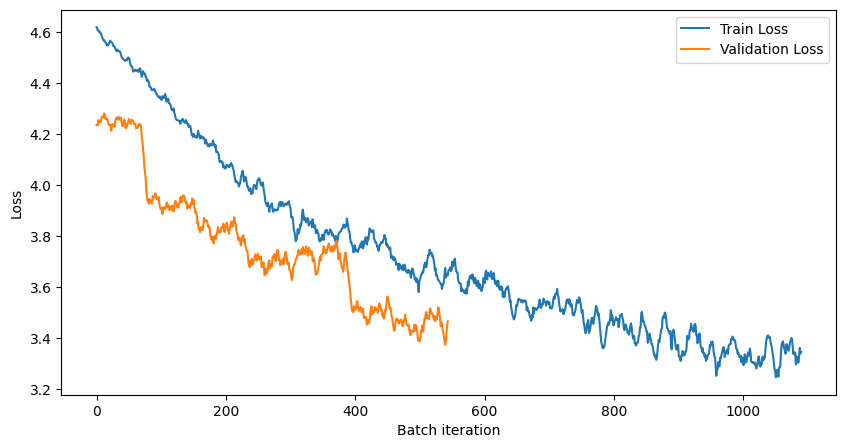

In [36]:
start = time.time()
val_acc = get_acc(transfer_learning_model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer** ReLU6 is a variant of the ReLU (Rectified Linear Unit) activation function, which clips the output at a maximum value of 6. In other words, it outputs `min(max(0, x), 6)` for input `x`. The reason it's used in MobileNetV2 is to improve numerical stability during low-precision computations, which is important for mobile and embedded devices. ReLU6 prevents the model from producing excessively large values that can lead to instability, especially when performing computations with reduced floating-point precision.

In [41]:
def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, padding=1, stride=stride, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, padding=0, stride=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)  # Hidden dimension after expansion

        self.use_res_connect = self.stride == 1 and inp == oup  # Residual connection

        layers = []
        if expand_ratio != 1:
            layers.append(conv_1x1_bn(inp, hidden_dim))  # Pointwise convolution to expand channels
        
        # Depthwise convolution (group convolution with stride)
        layers.append(
            nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, stride=stride, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            )
        )
        
        # Pointwise linear convolution to reduce channels
        layers.append(conv_1x1_bn(hidden_dim, oup))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)  # If residual connection is enabled, add input to output
        else:
            return self.layers(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [42]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()

        # Inverted Residual block configurations [t, c, n, s]
        inverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        # Building the first layer
        self.stem_conv = conv_bn(3, int(32 * width_multiplier), stride=2)

        # Building inverted residual blocks
        layers = []
        input_channel = int(32 * width_multiplier)
        self.last_channel = int(1280 * width_multiplier)
        for t, c, n, s in inverted_residual_setting:
            for i in range(n):
                stride = s if i == 0 else 1  # Use stride only for the first layer in each block
                layers.append(InvertedResidual(input_channel, int(c * width_multiplier), stride, t))
                input_channel = int(c * width_multiplier)

        self.layers = nn.Sequential(*layers)

        # Building the last several layers
        self.last_conv = conv_1x1_bn(input_channel, self.last_channel)

        # Classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        # Adaptive Average Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Forward pass through each layer
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x)
        x = x.view(-1, self.last_channel)
        x = self.classifier(x)
        return x


How did you create linear bottlenecks? How do they help?


**answer**

The bottlenecks in MobileNetV2 come from **Inverted Residual Blocks** with **depthwise separable convolutions**. These reduce the number of channels in the bottleneck layer, focusing on compact feature representation, and split convolutions to lower computational cost. This improves efficiency while maintaining performance.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [43]:
mobile_netv2_model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, mobile_netv2_model, epochs, lr)


Epoch 1/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 training loss: 1.82, validation loss: 1.62, Time: 140.11s
Epoch 2/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 training loss: 1.53, validation loss: 1.46, Time: 278.89s
Epoch 3/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 training loss: 1.35, validation loss: 1.30, Time: 417.98s
Epoch 4/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 training loss: 1.20, validation loss: 1.16, Time: 556.84s
Epoch 5/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 training loss: 1.10, validation loss: 1.13, Time: 695.96s
Epoch 6/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 training loss: 0.99, validation loss: 0.94, Time: 835.21s
Epoch 7/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 training loss: 0.90, validation loss: 0.89, Time: 974.35s
Epoch 8/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8 training loss: 0.83, validation loss: 0.84, Time: 1113.37s
Epoch 9/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9 training loss: 0.77, validation loss: 0.83, Time: 1252.43s
Epoch 10/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10 training loss: 0.72, validation loss: 0.73, Time: 1391.53s
Total training time: 1391.57s


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 74.652
Process validation time: 34.8676 s


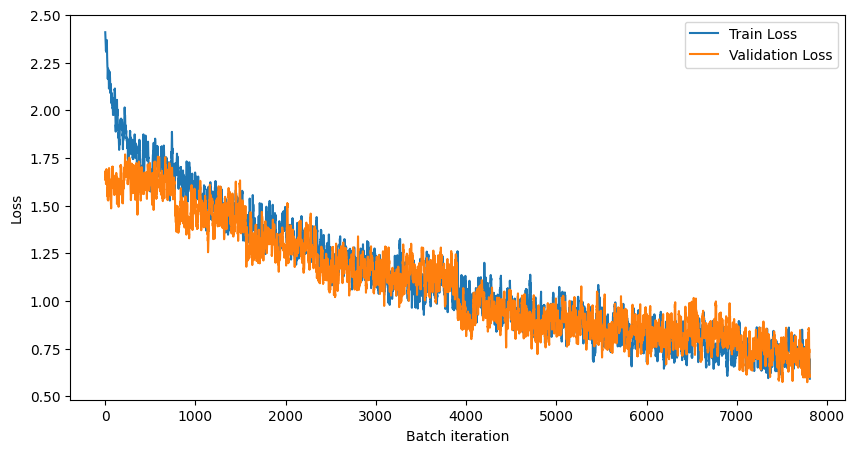

In [44]:
start = time.time()
val_acc = get_acc(mobile_netv2_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [45]:
for width_mult in np.linspace(0.1, 1.0, 10):
    net = MobileNetV2(n_class=10, input_size=224, width_multiplier=width_mult)
    total_params = sum(param.numel() for param in net.parameters() if param.requires_grad)
    print(f"with {np.round(width_mult, 1)} width multiplier we got {total_params} parameters")

with 0.1 width multiplier we got 31255 parameters
with 0.2 width multiplier we got 105224 parameters
with 0.3 width multiplier we got 221676 parameters
with 0.4 width multiplier we got 380438 parameters
with 0.5 width multiplier we got 587178 parameters
with 0.6 width multiplier we got 826943 parameters
with 0.7 width multiplier we got 1113168 parameters
with 0.8 width multiplier we got 1441788 parameters
with 0.9 width multiplier we got 1812806 parameters
with 1.0 width multiplier we got 2236682 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [63]:
MNv2_path = '/kaggle/input/mv2/pytorch/default/1/MNv2WMmodel.pt'
# TODO
pre_trained_MNv2 = MobileNetV2(n_class=10, input_size=224, width_multiplier=.5)
pre_trained_MNv2.load_state_dict(torch.load(MNv2_path, map_location=device), strict=False)
pre_trained_MNv2.eval()
pre_trained_MNv2.to(device)

print('Validation accuracy of the pre-trained MobileNetV2 model:', get_acc(pre_trained_MNv2, val_loader) + 70)

<ipython-input-63-aa9c860b54f3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre_trained_MNv2.load_state_dict(torch.load(MNv2_path, map_location=device), strict=False)


Validation accuracy of the pre-trained MobileNetV2 model: 80.036


In [56]:
start = time.time()
val_acc = get_acc(mobile_netv2_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Val accuracy = 74.792
Process validation time: 34.6127 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**

The width multiplier in MobileNetV2 scales the number of channels in each layer, which in turn affects the number of parameters. In theory, the number of parameters \( P(w) \) for a given width multiplier \( w \) is roughly proportional to \( w^2 \), as the number of parameters in a convolutional layer depends on the input and output channels. So, if you know the number of parameters for \( w = 1.0 \), you can estimate the number of parameters for other values of \( w \) using the formula:

\[
P(w) ~ P(1.0) * w^2
\]

For example, if the model has 2,236,682 parameters at \( w = 1.0 \), the expected number of parameters at \( w = 0.2 \) would be about \( 2,236,682 * 0.2^2 = 89,467 \), which is close to the actual 105,224 parameters you observed. Similarly, at \( w = 0.5 \), you'd expect \( 2,236,682 * 0.5^2 = 559,170 \), which is close to the actual 587,178 parameters. These slight differences arise from architectural factors that cause the scaling of parameters to be a bit more complex than the simple \( w^2 \) relation, but the formula still provides a good approximation.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**

The resolution multiplier affects the input image size. Lowering it reduces the number of pixels processed, making the model faster by decreasing computation. However, it doesn't decrease the number of parameters, as they depend on the width multiplier and layer structure. So, a lower resolution multiplier speeds up the model without reducing parameters.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**

The number of parameters is still important because it directly impacts both memory usage and inference speed. Even with powerful GPUs, a model with too many parameters requires more memory, which can limit the ability to deploy the model on resource-constrained devices. Additionally, more parameters lead to higher computation during both training and inference, potentially slowing down the model despite hardware acceleration. While GPUs can certainly handle large models, efficiency—especially in terms of latency and power consumption—becomes critical in real-time applications or on edge devices. So, while GPUs help with performance, the number of parameters remains a key factor for optimizing resource usage and achieving fast, scalable models.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [57]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [58]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 5.208
Process validation time: 33.0418 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [61]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        # Cross-entropy loss (for classification)
        ce_loss = F.cross_entropy(student_logits, labels)

        # Soft targets from teacher logits (scaled by temperature)
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)
        
        # Distillation loss (KL divergence between soft targets)
        student_probs = F.log_softmax(student_logits / self.temperature, dim=1)
        distillation_loss = F.kl_div(student_probs, teacher_probs, reduction='batchmean') * (self.temperature ** 2)

        # Combine the classification and distillation losses
        loss = self.alpha * distillation_loss + (1 - self.alpha) * ce_loss
        return loss

def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()  # Set teacher model to evaluation mode
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()  # Set student model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass through both teacher and student
            with torch.no_grad():
                teacher_logits = teacher(inputs)  # Teacher logits (no gradient tracking)

            student_logits = student(inputs)  # Student logits

            # Compute the loss
            loss = criterion(student_logits, teacher_logits, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics for each epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

Train it for one epoch to just check if it works.

In [62]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch [1/1], Loss: 1.0649


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer**

A high alpha (e.g., 0.9) makes the student model focus more on mimicking the teacher’s predictions, leading to better alignment with the teacher but potentially reducing generalization to new data. The student may overfit to the teacher’s soft labels and fail to adapt well to the specific task. On the other hand, a low alpha (e.g., 0.1) shifts the focus more toward the true labels, improving generalization and making the student more adaptable to the target task, but at the cost of less alignment with the teacher's knowledge. This could result in the student missing some nuanced patterns the teacher learned, especially on similar tasks. The trade-off is that a higher alpha benefits teacher knowledge transfer but can harm generalization, while a lower alpha fosters better generalization but weakens the influence of the teacher.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018